## Variable context text feature extraction

The goal with this experiment is to test how context size influences the predictivity of text features.

We will compare two main feature extraction strategies:

1. **short context**: features are computed for short sliding windows of text, one per TR (as in the algonauts dev kit).

2. **long context**: features are computed for the full episode text, after which per-TR features are extracted from the full sequence. The input text to the model will be:

    - (a) Full raw transcript text
    - (b) Transcript preceded by a short plot summary for context.


In [61]:
import re
import requests
import yaml
from pathlib import Path

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import h5py

In [2]:
data_dir = Path("/home/clane/algonauts_2025.competitors")

out_dir = Path("/home/clane/algonauts2025/text_feature_extraction/output")
out_dir.mkdir(exist_ok=True)

Load and quickly inspect the transcript to remind myself the format.

In [3]:
example_transcript_table = pd.read_csv(
    data_dir / "stimuli/transcripts/friends/s1/friends_s01e01a.tsv", sep="\t",
)

example_transcript_table.head(14)

,text_per_tr,words_per_tr,onsets_per_tr,durations_per_tr
0,NaN,[],[],[]
1,NaN,[],[],[]
2,NaN,[],[],[]
3,NaN,[],[],[]
4,NaN,[],[],[]
5,NaN,[],[],[]
6,NaN,[],[],[]
7,NaN,[],[],[]
8,NaN,[],[],[]
9,NaN,[],[],[]


Nb, tangent, but can download subtitles using subliminal pretty easily, but the onsets don't line up.

```
subliminal download -l en Friends.S01E01.HDTV.x264.mp4
```

Formatting per-TR text as a single text block, each TR on a different line.
I thought about concatenating lines, but decided the 1.5s per line gives the text whitespace nice meaning (i.e. dialogue pacing and pauses) which could be relevant to the model.

Also return the char index for the start of each TR (which we will use later for slicing into tokens.)

In [4]:
def format_text(transcript_table: pd.DataFrame):
    lines = [
        (line if line == line else "") + "\n"
        for line in transcript_table["text_per_tr"]
    ]
    text = "".join(lines)
    
    lengths = np.array([len(line) for line in lines])
    onsets = np.concatenate([[0], np.cumsum(lengths)[:-1]])
    return text, onsets

In [5]:
print(format_text(example_transcript_table.iloc[:40])[0])













There's 
nothing to tell. 
Just some guy I work 
with. Come on, 
you're going out with the guy. 
There's got to be something wrong with 
him. All right, 
joey, be nice. 
So does he have a hump? A 
hump and a hairpiece. 

Wait, does he eat 
chalk? 
Just because I don't want her to go through 
what I went through with 
Carl okay, everybody 
relax. Relax. 
This is not even a date. 
It's not? It's just two people going out 
to dinner and not having 
sex. 
Sounds like a date to 
me. 

All right, so I'm back in 
high school. I'm standing in the middle of the 
cafeteria and I realize I 
am totally 



Next load all the transcript tables.

In [6]:
def parse_friends_run(run: str):
    match = re.match(r"s([0-9]+)e([0-9]+)([a-z])", run)
    if match is None:
        raise ValueError(f"Invalid friends run {run}")

    season = int(match.group(1))
    episode = int(match.group(2))
    part = match.group(3)
    return season, episode, part

In [89]:
transcript_paths = sorted((data_dir / "stimuli/transcripts/friends").rglob("*.tsv"))
print("\n".join(map(str, transcript_paths[:4])))
print("\n".join(map(str, transcript_paths[-4:])))

/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s1/friends_s01e01a.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s1/friends_s01e01b.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s1/friends_s01e02a.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s1/friends_s01e02b.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s7/friends_s07e23a.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s7/friends_s07e23b.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s7/friends_s07e23c.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/friends/s7/friends_s07e23d.tsv


In [8]:
transcript_tables = {}

for path in transcript_paths:
    key = path.stem.split("_")[-1]
    season, ep, part = parse_friends_run(key)
    table = pd.read_csv(path, sep="\t")
    transcript_tables[(season, ep, part)] = table

Adding plot summaries.

I'm thinking it could be useful context to the model to include a short plot summary. Scraping summaries for each episode from wikipedia. (Thanks gpt for the help.)

Note, there is some complication in the scraping to handle a special case of two-part episodes, which happen about 1 per season.

In [9]:
def scrape_friends_summaries(season: int):
    # thx gpt
    url = f"https://en.wikipedia.org/wiki/Friends_season_{season}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    results = []
    episode_rows = soup.select("table.wikiepisodetable tr")

    current_title = None
    current_episode_numbers = []

    for row in episode_rows:
        # Row with episode metadata (title, number, etc.)
        if "vevent" in row.get("class", []):
            # Get episode number(s)
            episode_number_cell = row.find("th", scope="row")
            if episode_number_cell:
                raw_episode_number = episode_number_cell.get_text(separator=" ").strip()
                # Split multi-part episodes
                cell_episode_numbers = [
                    int(num) for num in raw_episode_number.strip().split() if num.isdigit()
                ]
                # Note, extend episode numbers to handle some multi-part epidosodes.
                current_episode_numbers.extend(cell_episode_numbers)

            # Get episode title
            title_cell = row.find("td", class_="summary")
            if title_cell:
                current_title = title_cell.get_text(strip=True).strip('"')

        # Row with the plot summary
        elif "expand-child" in row.get("class", []):
            summary_div = row.find("div", class_="shortSummaryText")
            if current_title and current_episode_numbers and summary_div:
                summary = summary_div.get_text(separator=" ", strip=True)

                # Create an entry for each episode number
                for ep_num in current_episode_numbers:
                    results.append((ep_num, current_title, summary))

                current_title = None
                current_episode_numbers = []

    results = {
        (season, ep): {"title": title, "summary": summary}
        for (ep, title, summary) in results
    }

    return results


In [10]:
redownload_summaries = False

if redownload_summaries:
    friends_episode_summaries = {}

    for season in range(1, 8):
        friends_episode_summaries.update(scrape_friends_summaries(season))

    # re-number season episodes 
    season_episode_starts = {}
    for season, ep in friends_episode_summaries:
        if season not in season_episode_starts:
            season_episode_starts[season] = ep

    friends_episode_summaries = {
        (season, ep - season_episode_starts[season] + 1): summary
        for (season, ep), summary in friends_episode_summaries.items()
    }

    # format season episode keys
    friends_episode_summaries = {
        f"s{season:02d}e{ep:02d}": summary
        for (season, ep), summary in friends_episode_summaries.items()
    }

    with (out_dir / "friends_episode_summaries.yaml").open("w") as f:
        yaml.safe_dump(friends_episode_summaries, f, sort_keys=False)
else:
    with (out_dir / "friends_episode_summaries.yaml").open() as f:
        friends_episode_summaries = yaml.safe_load(f)

In [11]:
example_summary = friends_episode_summaries["s01e01"]

print(
    f"{example_summary['title']}\n\n{example_summary['summary']}"
)

Pilot"[a]"The One Where Monica Gets a Roommate

After leaving her fiancé, Barry, at the altar, Rachel finds herself in Central Perk Café, soaking wet in her wedding dress, looking for her old friend Monica. Rachel ends up moving into Monica's New York apartment. Chandler and Joey, who live across the hall from Monica, console Monica's brother, Ross, whose wife, Carol, has just left him for a woman; Rachel's reappearance revives Ross' crush on her, which dates back to high school. Monica falls for Paul "the wine guy," only to be crushed to learn that he lied about a bad breakup to have a one-night stand with her. The gang urges Rachel to be more independent by cutting up her father's credit cards; Rachel, who has never worked before, subsequently gets a job as a waitress at Central Perk. Guest Starring: John Allen Nelson as Paul, Clea Lewis as Franny


In [12]:
# Check that no missing episodes.
# (Before, I missed some two part episodes.)
missing_episodes = {}
for season, ep, _ in transcript_tables:
    key = f"s{season:02d}e{ep:02d}"
    if key not in friends_episode_summaries:
        missing_episodes[key] = True

print("Missing episodes:", missing_episodes)

Missing episodes: {}


Tokenizing.

For the long context extraction, we need a way of getting per-TR features from the full sequence of embeddings. Our strategy is to:

1. Find the char index slices into the full text corresponding to each TR.
2. Use the returned token `offsets_mapping` from the tokenizer to convert char text slices to token slices. (See e.g. [here](https://huggingface.co/learn/llm-course/en/chapter6/3) for more details on the offsets mapping.)
3. Average pool over the tokens corresponding to each TR.

    - Nb, alternatively could do sliding window averages of a fixed size, ending with the last token of each TR. Fixed size could even be 1, to just get the last token of each TR.

In [13]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [16]:
# Nb, using NVIDIA RTX 6000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(device))

Running on: cuda:0
NVIDIA RTX 6000 Ada Generation


Using a small Llama model for this test. Arbitrary choice, except for wanting something smallish.

> **Todo**: compare other models.

In [17]:
model_id = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [26]:
text, onsets = format_text(example_transcript_table)
token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")

In [30]:
print("Text[10:100]:\n", text[10:100], "\n")

print("TR char onsets shape:", onsets.shape)
print("TR char onsets[:16]:\n", onsets[:16], "\n")

print("Token input ids shape:", token_dict["input_ids"].shape)
print("Token input ids[:10]:\n", token_dict["input_ids"][0, :10])

print("Token offsets mapping shape:", token_dict["offset_mapping"].shape)
print("Token offsets mapping[:10]:\n", token_dict["offset_mapping"][0, :10])

Text[10:100]:
 

There's 
nothing to tell. 
Just some guy I work 
with. Come on, 
you're going out with t 

TR char onsets shape: (591,)
TR char onsets[:16]:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 21 39 61] 

Token input ids shape: (1, 2791)
Token input ids[:10]:
 [128000  46228   3947    596    720  42312    311   3371     13    720]
Token offsets mapping shape: (1, 2791, 2)
Token offsets mapping[:10]:
 [[ 0  0]
 [ 0 12]
 [12 17]
 [17 19]
 [19 21]
 [21 28]
 [28 31]
 [31 36]
 [36 37]
 [37 39]]


Get token slices corresponding to each TR.

In [31]:
def get_tr_token_onsets(token_offset_mapping: np.ndarray, tr_char_onsets: np.ndarray):
    tr_token_onsets = np.searchsorted(
        token_offset_mapping[:, 1] - 1, tr_char_onsets, side="left"
    )
    windows = np.diff(tr_token_onsets, append=[len(token_offset_mapping)])
    windows = np.maximum(windows, 1)
    tr_token_onsets = np.stack([tr_token_onsets, tr_token_onsets + windows], axis=1)
    return tr_token_onsets

In [32]:
tr_token_onsets = get_tr_token_onsets(token_dict["offset_mapping"][0], onsets)

Check that slicing the text by either:

- TR char onsets
- TR char onsets -> token onsets -> token char onsets

produces the same text.

In [38]:
for idx in range(20, 30):
    start_token, stop_token = tr_token_onsets[idx]
    start_char = token_dict["offset_mapping"][0, start_token, 0]
    stop_char = token_dict["offset_mapping"][0, stop_token, 0]

    print(f"tr={idx} [{start_token}:{stop_token}]")
    print(repr(text[onsets[idx]: onsets[idx + 1]]))
    print(repr(text[start_char: stop_char]))

tr=20 [53:63]
'So does he have a hump? A \n'
'So does he have a hump? A \n'
tr=21 [63:70]
'hump and a hairpiece. \n'
'hump and a hairpiece.'
tr=22 [70:71]
'\n'
' \n\n'
tr=23 [71:77]
'Wait, does he eat \n'
'Wait, does he eat \n'
tr=24 [77:80]
'chalk? \n'
'chalk? \n'
tr=25 [80:91]
"Just because I don't want her to go through \n"
"Just because I don't want her to go through \n"
tr=26 [91:97]
'what I went through with \n'
'what I went through with \n'
tr=27 [97:102]
'Carl okay, everybody \n'
'Carl okay, everybody \n'
tr=28 [102:108]
'relax. Relax. \n'
'relax. Relax. \n'
tr=29 [108:116]
'This is not even a date. \n'
'This is not even a date. \n'


Feature extraction

Copied from [here](https://www.kaggle.com/code/ckadirt/features-extraction-algonauts2025) with some modifications. (Although he initially copied from me and modified, hah :).)

In [39]:
import fnmatch
from typing import Any, Dict, List, Tuple
from torch import nn


class HuggingFaceFeatureExtractor:
    """
    A feature extractor for Hugging Face (or any PyTorch) models that captures
    intermediate activations from any layer specified by exact name or glob pattern.

    Example usage:
        from transformers import BertModel
        model = BertModel.from_pretrained("bert-base-uncased")
        # Specify layers (using glob patterns is supported)
        layers_to_extract = ["encoder.layer.*.output"]

        # Using the extractor as a context manager ensures hooks are removed automatically.
        with HuggingFaceFeatureExtractor(model, layers_to_extract) as extractor:
            # Perform a forward pass as usual
            outputs = model(input_ids, attention_mask=mask)
            # Get a copy of the extracted features
            features = extractor.features
            # Now 'features' is a dict mapping layer names to their activation tensors.
    """

    def __init__(self, model: nn.Module, layers: List[str]):
        self.model = model
        # Expand layer patterns into full module names
        self.layers = self._expand_layers(model, layers)
        self._features: Dict[str, Any] = {}
        self._handles: Dict[str, Any] = {}
        self._register_hooks()

    def _register_hooks(self):
        """Register forward hooks on each specified layer."""
        for layer in self.layers:
            sub_module = self.model.get_submodule(layer)
            handle = sub_module.register_forward_hook(self._make_hook(layer))
            self._handles[layer] = handle

    def _make_hook(self, layer_name: str):
        def hook(module: nn.Module, inputs: Tuple[Any, ...], output: Any):
            self._features[layer_name] = output
        return hook

    def clear(self):
        """Clear the stored features before a new forward pass."""
        self._features.clear()

    @property
    def features(self) -> Dict[str, Any]:
        """Return a copy of the captured features."""
        return dict(self._features)

    def __call__(self, *args, **kwargs) -> Any:
        """
        Run the model forward. This automatically clears previous features,
        then performs a forward pass, capturing intermediate activations.
        Returns the model's original output.
        """
        self.clear()
        return self.model(*args, **kwargs)

    def remove_hooks(self):
        """Remove all registered hooks."""
        for handle in self._handles.values():
            handle.remove()
        self._handles.clear()

    def __enter__(self):
        """Enter context: hooks are already registered."""
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Exit context: remove all hooks."""
        self.remove_hooks()

    @staticmethod
    def _expand_layers(model: nn.Module, layers: List[str]) -> List[str]:
        """
        Expand a list of layer names and/or glob patterns to all matching module names
        in the given model. Raises an error if a specified name or pattern doesn't match.
        """
        all_layers = [name for name, _ in model.named_modules() if name]  # skip the root module ''
        all_layers_set = set(all_layers)
        expanded = []
        special_chars = set("*?[]")
        for layer in layers:
            if not any(char in layer for char in special_chars):
                if layer not in all_layers_set:
                    raise ValueError(f"Layer '{layer}' not found in the model.")
                expanded.append(layer)
            else:
                matches = fnmatch.filter(all_layers, layer)
                if not matches:
                    raise ValueError(f"No layers match the pattern '{layer}'.")
                expanded.extend(matches)
        return expanded

In [40]:
model = AutoModelForCausalLM.from_pretrained(model_id)
model = model.to(device)
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

Extract features from a few transformer blocks.

> **TODO**: Try some other layers maybe

In [41]:
extractor = HuggingFaceFeatureExtractor(
    model,
    layers=[f"model.layers.{ii}" for ii in [7, 11, 15]],
)

Formatting long context model input, with option to include the plot summary.

In [44]:
def format_model_input(
    season: int,
    episode: int,
    part: str,
    *,
    with_summary: bool = True,
):
    table = transcript_tables[(season, episode, part)]
    transcript, onsets = format_text(table)

    prefix = f"Friends S{season:02d}E{episode:02d}\n\n"
    
    if with_summary:
        key = f"s{season:02d}e{episode:02d}"
        title = friends_episode_summaries[key]["title"]
        summary = friends_episode_summaries[key]["summary"]
        summary = f"{title}\n\nWiki plot summary:\n\n{summary}\n\n"
        prefix = prefix + summary

    prefix = prefix + (
        f"Transcript (Part {part.upper()}) "
        "(each line corresponds to 1.5s of show run time):\n"
    )
    text = prefix + transcript
    onsets = onsets + len(prefix)
    return text, onsets

In [45]:
for with_summary in [True, False]:
    text, onsets = format_model_input(4, 8, "b", with_summary=with_summary)

    # save out for inspection 
    with (out_dir / f"format_text_long_summary-{int(with_summary)}.txt").open("w") as f:
        print(text, file=f)

Check that the token slicing still works after adding the summary.

In [47]:
text, onsets = format_model_input(4, 8, "b", with_summary=True)

token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
tr_token_onsets = get_tr_token_onsets(
    token_dict["offset_mapping"][0], onsets
)        

In [49]:
for idx in range(0, 20):
    start_token, stop_token = tr_token_onsets[idx]
    start_char = token_dict["offset_mapping"][0, start_token, 0]
    stop_char = token_dict["offset_mapping"][0, stop_token, 0]

    print(f"tr={idx} [{start_token}:{stop_token}]")
    print(repr(text[onsets[idx]: onsets[idx + 1]]))
    print(repr(text[start_char: stop_char]))

tr=0 [213:221]
'You made her walk the plank. \n'
'You made her walk the plank. \n'
tr=1 [221:227]
'Eye, matey. \n'
'Eye, matey. \n'
tr=2 [227:231]
"You're not \n"
"You're not \n"
tr=3 [231:237]
'wearing the patch yet. \n'
'wearing the patch yet.'
tr=4 [237:238]
'\n'
' \n\n\n'
tr=5 [237:238]
'\n'
' \n\n\n'
tr=6 [238:241]
'I know. \n'
'I know.'
tr=7 [241:242]
'\n'
' \n\n\n\n\n'
tr=8 [241:242]
'\n'
' \n\n\n\n\n'
tr=9 [241:242]
'\n'
' \n\n\n\n\n'
tr=10 [241:242]
'\n'
' \n\n\n\n\n'
tr=11 [242:248]
"He's coming here for \n"
"He's coming here for \n"
tr=12 [248:257]
"Thanksgiving? I know. It's \n"
"Thanksgiving? I know. It's \n"
tr=13 [257:264]
'sick. Why is it \n'
'sick. Why is it \n'
tr=14 [264:271]
"sick? Because it's \n"
"sick? Because it's \n"
tr=15 [271:280]
"Richard's son. It's like inviting \n"
"Richard's son. It's like inviting \n"
tr=16 [280:286]
'a Greek tragedy over for \n'
'a Greek tragedy over for \n'
tr=17 [286:290]
'dinner. \n'
'dinner. \n'
tr=18 [290:298]
"If it were Greek, I

Pooling features over spans of tokens corresponding to each TR.

Nb, doing in a loop. Could possibly think of a vectorized impl with matmul, but prob not necessary.

In [51]:
def pool_tr_features(features: torch.Tensor, tr_token_onsets: np.ndarray):
    features = features.squeeze()
    N, C = features.shape
    T = len(tr_token_onsets)
    tr_features = torch.zeros(T, C, device=features.device, dtype=features.dtype)
    for ii in range(T):
        start_token, stop_token = tr_token_onsets[ii]
        assert stop_token > start_token
        tr_features[ii] = features[start_token: stop_token].mean(axis=0)
    return tr_features

In [52]:
text, onsets = format_model_input(4, 8, "b", with_summary=True)

token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
tr_token_onsets = get_tr_token_onsets(token_dict["offset_mapping"][0], onsets)        

with torch.no_grad():
    input_ids = torch.from_numpy(token_dict["input_ids"]).to(device)
    extractor(input_ids)
    features = extractor.features

In [53]:
features["model.layers.11"][0].shape, features["model.layers.11"][0].dtype

(torch.Size([1, 2275, 2048]), torch.float32)

In [59]:
tr_features = pool_tr_features(features["model.layers.11"][0], tr_token_onsets)
tr_features = tr_features.cpu().numpy()

print("Pooled features:", tr_features.shape)
print("Transcript table:", transcript_tables[4, 8, "b"].shape)


Pooled features: (502, 2048)
Transcript table: (502, 4)


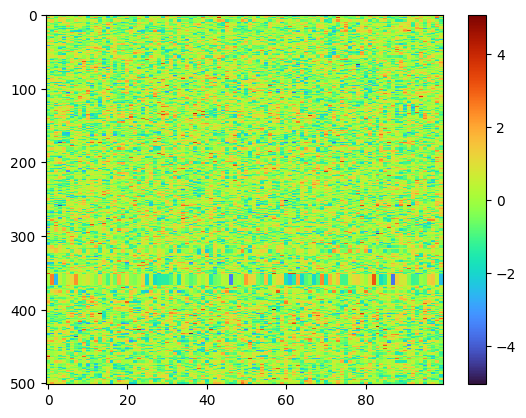

In [60]:

def scale(x: np.ndarray):
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

plt.imshow(scale(tr_features[:, :100]), interpolation="none", cmap="turbo", aspect="auto")
plt.colorbar()
plt.show()

Now actual feature extraction and saving to h5.

In [87]:
@torch.no_grad()
def extract_long_context_features(with_summary: bool = True):
    for season, ep, part in tqdm(transcript_tables):
        text, onsets = format_model_input(
            season, ep, part, with_summary=with_summary
        )

        token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
        tr_token_onsets = get_tr_token_onsets(
            token_dict["offset_mapping"][0], onsets
        )        

        input_ids = torch.from_numpy(token_dict["input_ids"]).to(device)
        extractor(input_ids)

        for lyr, feat in extractor.features.items():
            if isinstance(feat, tuple):
                feat = feat[0]
            pool_feat = pool_tr_features(feat, tr_token_onsets).cpu().numpy()

            # key = f"s{season:02d}e{ep:02d}{part}/{lyr}"
            yield (season, ep, part, lyr), pool_feat

In [90]:
out_prefix = (out_dir / f"features/friends/{model_id.replace("/", "__")}")

for with_summary in [True, False]:
    out_path = out_prefix / f"context-long_summary-{int(with_summary)}.h5"
    out_path.parent.mkdir(exist_ok=True, parents=True)
    
    with h5py.File(out_path, "w") as file:
        for (season, ep, part, lyr), feat in extract_long_context_features(
            with_summary=with_summary
        ):
            key = f"s{season:02d}e{ep:02d}{part}/{lyr}"
            file[key] = feat

  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [02:15<00:00,  2.52it/s]


Next we save out the baseline short context sliding window features. Here we include N tokens of preceding context, following the algonauts dev kit.

Note, not every token sequence starts with the BOS token. I think this is how it should be, but should double check.

In [122]:
def generate_sliding_window_tokens(
    transcript_table: pd.DataFrame, window_size: int = 32
):
    _, eos_token_id = tokenizer(tokenizer.eos_token)["input_ids"]

    text, onsets = format_text(transcript_table)
    
    token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
    tr_token_onsets = get_tr_token_onsets(
        token_dict["offset_mapping"][0], onsets
    )
    
    all_input_ids = token_dict["input_ids"][0]
    batch_input_ids = []
    for _, stop_token in tr_token_onsets:
        start_token = max(stop_token - window_size, 0)
        tr_input_ids = all_input_ids[start_token: stop_token]

        if len(tr_input_ids) < window_size:
            tr_input_ids = np.pad(
                tr_input_ids,
                (0, window_size - len(tr_input_ids)),
                constant_values=eos_token_id,
            )
        batch_input_ids.append(tr_input_ids)

    batch_input_ids = np.stack(batch_input_ids)

    assert batch_input_ids.shape == (len(transcript_table), window_size)
    return batch_input_ids

In [124]:
batch_input_ids = generate_sliding_window_tokens(example_transcript_table, 8)
batch_input_ids[10:20]

array([[128000,  46228, 128001, 128001, 128001, 128001, 128001, 128001],
       [128000,  46228, 128001, 128001, 128001, 128001, 128001, 128001],
       [128000,  46228,   3947,    596,    720, 128001, 128001, 128001],
       [  3947,    596,    720,  42312,    311,   3371,     13,    720],
       [    13,    720,  10156,   1063,   7564,    358,    990,    720],
       [   990,    720,   4291,     13,  15936,    389,     11,    720],
       [  2351,   2133,    704,    449,    279,   7564,     13,    720],
       [   596,   2751,    311,    387,   2555,   5076,    449,    720],
       [   449,    720,  40617,     13,   2052,   1314,     11,    720],
       [   720,   7453,   1216,     11,    387,   6555,     13,    720]])

In [128]:
batch_input_ids = generate_sliding_window_tokens(example_transcript_table, 32)

with torch.no_grad():
    extractor(torch.from_numpy(batch_input_ids).to(device))
    features = extractor.features

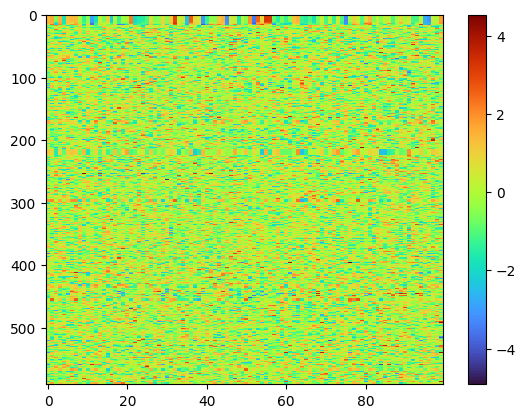

In [129]:
tr_features = features["model.layers.11"][0][:, -1].cpu().numpy()

plt.imshow(scale(tr_features[:, :100]), interpolation="none", cmap="turbo", aspect="auto")
plt.colorbar()
plt.show()

In [130]:
# Alternatively, could input sliding windows of text that go back a fixed number of TRs.
# This would result in a fixed duration of show time per TR, though not a fixed number
# of token content.

def format_sliding_window_text(transcript_table: pd.DataFrame, size: int = 5):
    tr_texts = []
    for tr_idx in range(len(transcript_table)):
        start_idx = max(tr_idx - size + 1, 0)
        lines = [
            (line if line == line else "")
            for line in transcript_table["text_per_tr"][start_idx: tr_idx + 1]
        ]
        text = "".join(lines)
        tr_texts.append(text)
    
    return tr_texts

In [131]:
batch_text = format_sliding_window_text(example_transcript_table, 3)
batch_text[10: 20]

['',
 '',
 "There's ",
 "There's nothing to tell. ",
 "There's nothing to tell. Just some guy I work ",
 'nothing to tell. Just some guy I work with. Come on, ',
 "Just some guy I work with. Come on, you're going out with the guy. ",
 "with. Come on, you're going out with the guy. There's got to be something wrong with ",
 "you're going out with the guy. There's got to be something wrong with him. All right, ",
 "There's got to be something wrong with him. All right, joey, be nice. "]

In [132]:
tokenizer.pad_token = tokenizer.eos_token

batch_token_dict = tokenizer(
    batch_text,
    padding=True,
    return_tensors="pt",
)

with torch.no_grad():
    batch_input_ids = batch_token_dict["input_ids"].to(device)
    extractor(batch_input_ids)
    features = extractor.features

Though there seems to be an issue due to not enough context in some TRs..

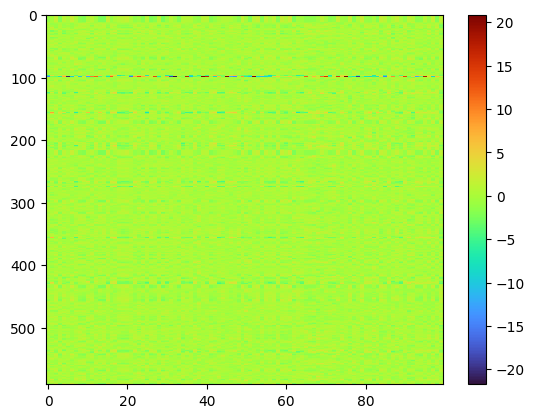

In [134]:
tr_features = features["model.layers.11"][0][:, -1].cpu().numpy()

plt.imshow(scale(tr_features[:, :100]), interpolation="none", cmap="turbo", aspect="auto")
plt.colorbar()
plt.show()

In [ ]:
@torch.no_grad()
def extract_short_context_features(window_size: int = 32):
    for (season, ep, part), table in tqdm(transcript_tables.items()):
        batch_input_ids = generate_sliding_window_tokens(table, window_size)
        batch_input_ids = torch.from_numpy(batch_input_ids).to(device)
        extractor(batch_input_ids)

        for lyr, feat in extractor.features.items():
            if isinstance(feat, tuple):
                feat = feat[0]
            assert len(feat) == len(table)
            # Get feature vector for last token
            # Nb, could also average pool.
            pool_feat = feat[:, -1].cpu().numpy()
            yield (season, ep, part, lyr), pool_feat

In [137]:
out_prefix = (out_dir / f"features/friends/{model_id.replace("/", "__")}")

for window_size in [16, 32]:
    out_path = out_prefix / f"context-short_window-{window_size}.h5"
    out_path.parent.mkdir(exist_ok=True, parents=True)
    
    with h5py.File(out_path, "w") as file:
        for (season, ep, part, lyr), feat in extract_short_context_features(
            window_size=window_size
        ):
            key = f"s{season:02d}e{ep:02d}{part}/{lyr}"
            file[key] = feat

  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [10:24<00:00,  1.83s/it]
